In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, boxcox, pearsonr, ks_2samp

# from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, HuberRegressor, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

import lightgbm as lgb
import xgboost as xgb

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from Dataset import RegionalDatasets

from ModelOptimizer import (
    lgbm_optimizer, 
    xgb_optimizer, 
    rf_optimizer, 
    svr_optimizer, 
    ridge_optimizer, 
    huber_optimizer,
    knn_optimizer,
    lasso_optimizer,
    elasticnet_optimizer,
    model_box
)

from MetaModel import RegionalBasedPredictors, StackingPredictor

In [2]:
def metric_train(output, truth):
    return spearmanr(output, truth).correlation

def my_metric(output, data):
    return "spearman", spearmanr(output, data.get_label()).correlation, True

In [3]:
X_train = pd.read_csv("X_train_NHkHMNU.csv").set_index("ID")
y_train = pd.read_csv("y_train_ZAN5mwg.csv").set_index("ID")
X_test = pd.read_csv("X_test_final.csv").set_index("ID")
X_train.shape, y_train.shape, X_test.shape

((1494, 34), (1494, 1), (654, 34))

In [4]:
X_train.describe().loc[["mean", "std"]].T

,mean,std
DAY_ID,591.861446,345.065043
DE_CONSUMPTION,0.427442,0.673412
FR_CONSUMPTION,-0.020032,0.918995
DE_FR_EXCHANGE,-0.145508,0.970226
FR_DE_EXCHANGE,0.145508,0.970226
DE_NET_EXPORT,-0.256332,0.957443
FR_NET_EXPORT,-0.072643,1.075830
DE_NET_IMPORT,0.256332,0.957443
FR_NET_IMPORT,0.072643,1.075830
DE_GAS,0.780699,0.850190


In [5]:
X_test.describe().loc[["max", "min", "mean"]].T

,max,min,mean
DAY_ID,1214.000000,4.000000,632.744648
DE_CONSUMPTION,1.851717,-7.433311,0.435242
FR_CONSUMPTION,2.817944,-4.591011,0.034431
DE_FR_EXCHANGE,2.437265,-2.226614,-0.044960
FR_DE_EXCHANGE,2.226614,-2.437265,0.044960
DE_NET_EXPORT,2.104596,-2.413888,-0.221057
FR_NET_EXPORT,1.935559,-2.532384,-0.124737
DE_NET_IMPORT,2.413888,-2.104596,0.221057
FR_NET_IMPORT,2.532384,-1.935559,0.124737
DE_GAS,3.292225,-1.498254,0.822771


In [6]:
set(X_train.DAY_ID).intersection(set(X_test.DAY_ID))

set()

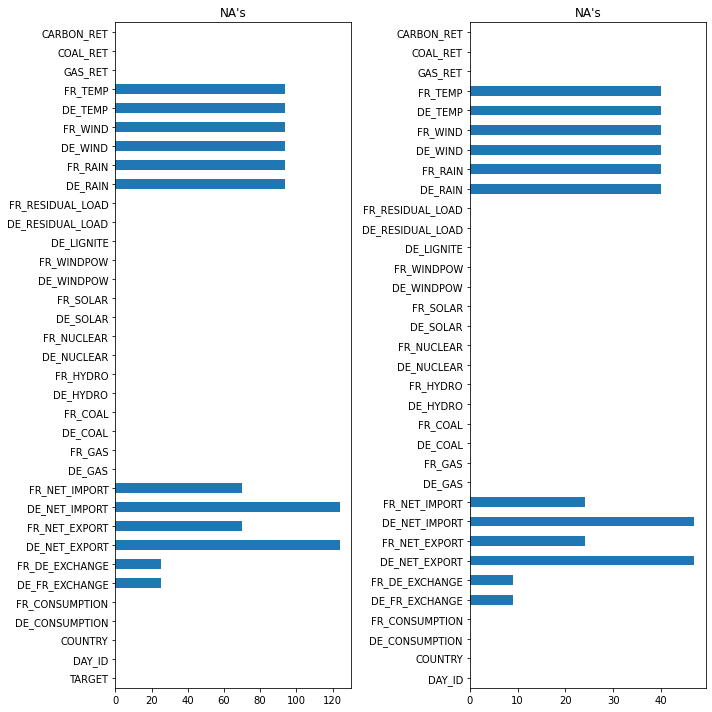

In [7]:
full_train = y_train.join(X_train)
full_train = full_train.replace("FR", 0)
full_train = full_train.replace("DE", 1)

X_test = X_test.replace("FR", 0)
X_test = X_test.replace("DE", 1)

fig, axs = plt.subplots(1,2,figsize=(10,10))
full_train.isna().sum(axis=0).plot(kind="barh", title="NA's", ax=axs[0])
X_test.isna().sum(axis=0).plot(kind="barh", title="NA's", ax=axs[1])
plt.tight_layout()

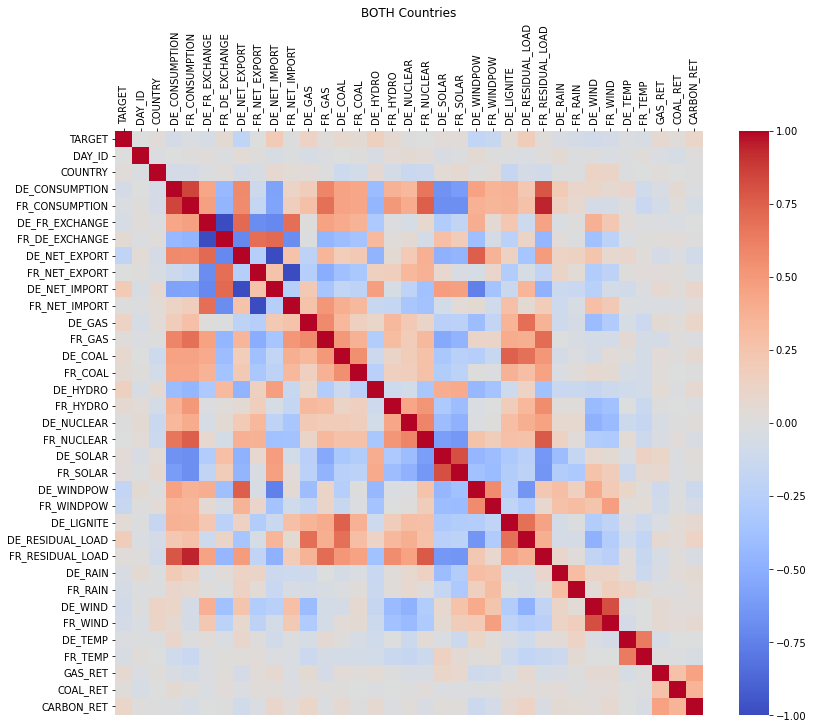

In [8]:
corr_train = full_train.corr(method="spearman")
plt.figure(figsize=(12,10))
ax = sns.heatmap(corr_train, cmap='coolwarm')
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("BOTH Countries")
plt.show()

In [9]:
weather = ["FR_TEMP", "DE_TEMP", "FR_WIND", "DE_WIND", "FR_RAIN", "DE_RAIN"]
full_train[weather] = full_train[weather].fillna(full_train[weather].mean())
X_test[weather] = X_test[weather].fillna(full_train[weather].mean())

related_cols = corr_train.columns.to_list()[4:-5]
imputer = KNNImputer(n_neighbors=5)
imputer.fit(full_train[related_cols])
full_train[related_cols] = imputer.transform(full_train[related_cols])
X_test[related_cols] = imputer.transform(X_test[related_cols])

In [10]:
fe1_train = full_train.sort_values("DAY_ID")
fe1_train['RANK'] = full_train.TARGET.rank()

In [11]:
day_count = fe1_train.groupby("DAY_ID")["RANK"].count()
idxs_1 = day_count[day_count == 1].index.to_list()
idxs_2 = day_count[day_count == 2].index.to_list()

df_same_day = fe1_train.loc[fe1_train["DAY_ID"].isin(idxs_2)]
df_same_day.head(4)

,TARGET,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,RANK
ID,,,,,,,,,,,,,,,,,,,,,
1327,2.575976,2,0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.14092,0.900434,1451.0
111,0.861270,2,1,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.14092,0.900434,1343.0
2016,0.068905,3,0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.06455,-0.032756,895.0
800,7.138604,3,1,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.06455,-0.032756,1493.0


In [12]:
df_single_day = fe1_train.loc[fe1_train["DAY_ID"].isin(idxs_1)]
df_single_day.head(4)

,TARGET,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,RANK
ID,,,,,,,,,,,,,,,,,,,,,
1057,0.108953,0,0,0.048418,-0.465067,-0.079296,0.079296,-0.222254,0.650577,0.222254,...,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,960.0
1179,-0.063369,1,0,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,...,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,611.0
1106,-0.123739,15,0,0.225040,-0.380781,0.342203,-0.342203,0.968306,0.234530,-0.968306,...,-0.693404,-0.850386,-0.915662,-1.069080,-0.639265,-0.047712,0.605670,0.234493,0.840556,508.0
1170,-1.854479,18,0,1.254269,2.267644,1.677301,-1.677301,1.450056,-0.346182,-1.450056,...,-0.690319,-0.551568,-0.666652,-1.007217,-0.260168,-1.327920,-1.196786,1.367880,0.122051,34.0


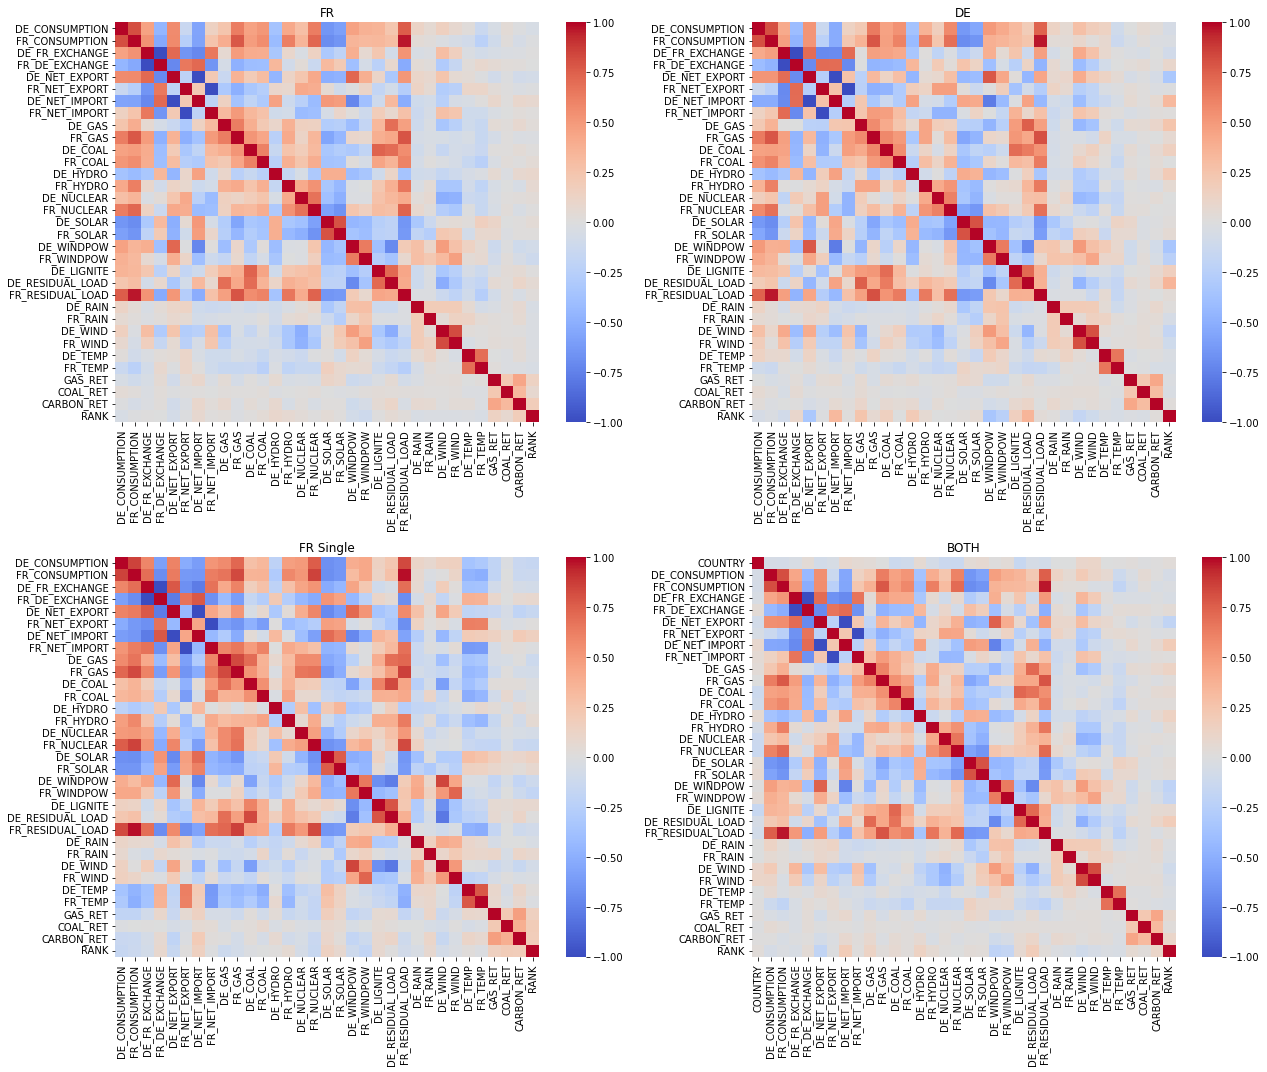

In [13]:
fr_corr = fe1_train.loc[fe1_train.COUNTRY == 0].drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1).corr(method="pearson")
fr_single_corr = df_single_day.drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1).corr(method="pearson")
de_corr = fe1_train.loc[fe1_train.COUNTRY == 1].drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1).corr(method="pearson")
both_corr = fe1_train.drop(["DAY_ID", "TARGET"], axis=1).corr(method="pearson")

fig, axs = plt.subplots(2, 2, figsize=(18,15))
sns.heatmap(fr_corr, cmap='coolwarm', ax=axs[0][0])
axs[0][0].set_title("FR")
sns.heatmap(de_corr, cmap='coolwarm', ax=axs[0][1])
axs[0][1].set_title("DE")
sns.heatmap(fr_single_corr, cmap='coolwarm', ax=axs[1][0])
axs[1][0].set_title("FR Single")
sns.heatmap(both_corr, cmap='coolwarm', ax=axs[1][1])
axs[1][1].set_title("BOTH")
fig.tight_layout()
plt.show()

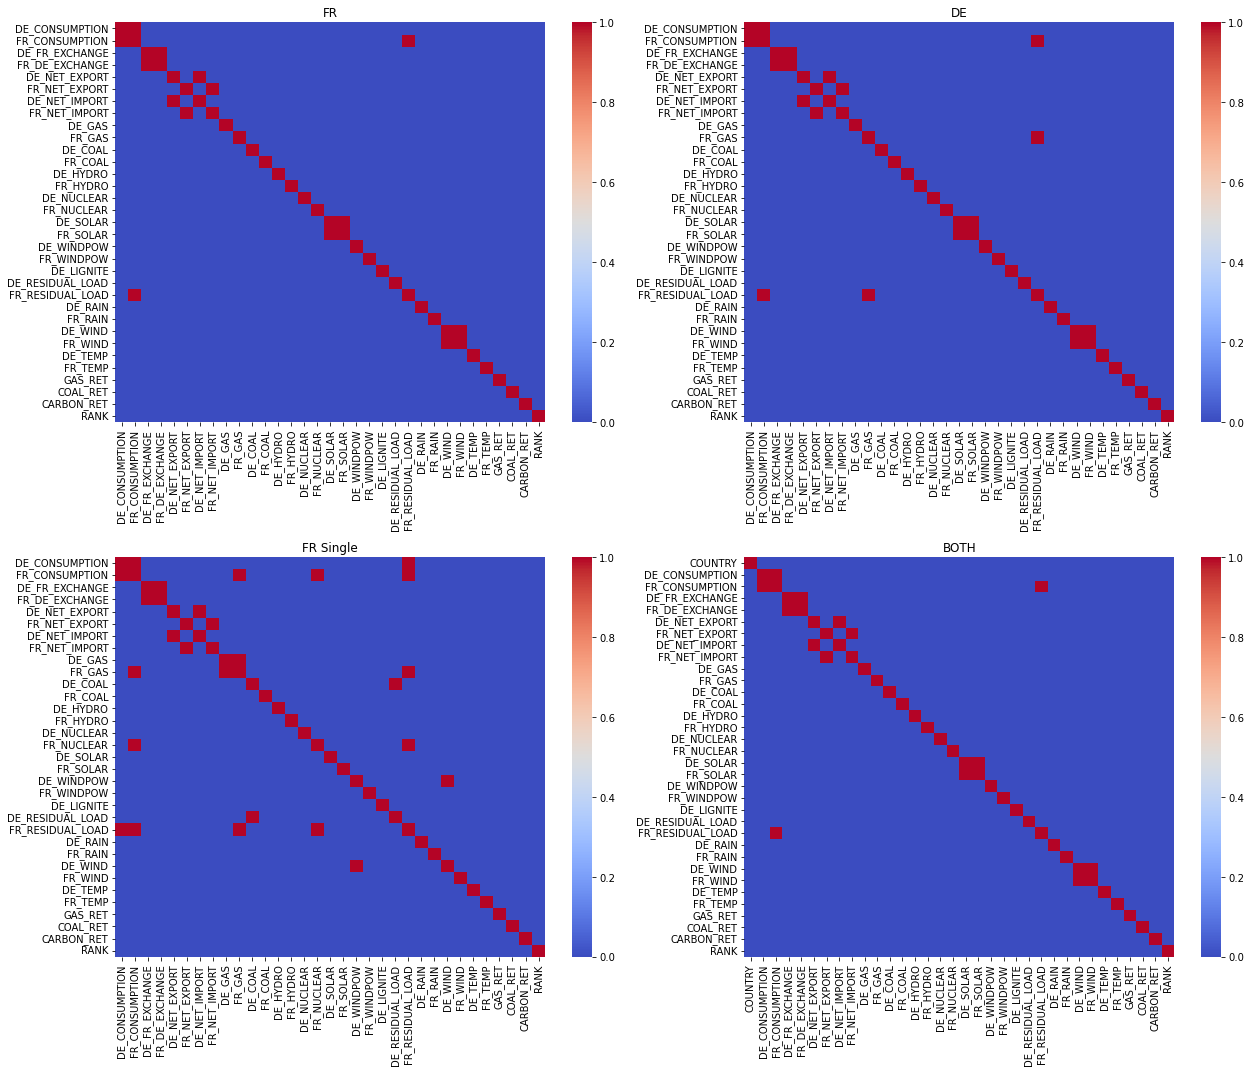

In [14]:
thres = 0.8
fig, axs = plt.subplots(2, 2, figsize=(18,15))
sns.heatmap(fr_corr.abs() > thres, cmap='coolwarm', ax=axs[0][0])
axs[0][0].set_title("FR")
sns.heatmap(de_corr.abs() > thres, cmap='coolwarm', ax=axs[0][1])
axs[0][1].set_title("DE")
sns.heatmap(fr_single_corr.abs() > thres, cmap='coolwarm', ax=axs[1][0])
axs[1][0].set_title("FR Single")
sns.heatmap(both_corr.abs() > thres, cmap='coolwarm', ax=axs[1][1])
axs[1][1].set_title("BOTH")
fig.tight_layout()
plt.show()

In [15]:
def feat_selector(corr):
    multi = corr[(corr.abs() > thres)]
    multi = multi.stack().index.to_list()
    dependency = {}
    for pair in multi:
        if pair[0] != pair[1]:
            winner = corr.loc["RANK", [pair[0], pair[1]]].abs().idxmax()
            loser = corr.loc["RANK", [pair[0], pair[1]]].abs().idxmin()
            if dependency.get(winner):
                if loser not in dependency[winner]:
                    dependency[winner].append(loser)
            else:
                dependency[winner] = [loser]
            # print(pair, corr.loc["RANK", [pair[0], pair[1]]].abs().idxmax())
    return dependency

feat_selector(fr_single_corr)

{'DE_CONSUMPTION': ['FR_CONSUMPTION', 'FR_RESIDUAL_LOAD'],
 'FR_CONSUMPTION': ['FR_GAS', 'FR_RESIDUAL_LOAD'],
 'FR_NUCLEAR': ['FR_CONSUMPTION', 'FR_RESIDUAL_LOAD'],
 'DE_FR_EXCHANGE': ['DE_FR_EXCHANGE'],
 'FR_DE_EXCHANGE': ['FR_DE_EXCHANGE'],
 'DE_NET_EXPORT': ['DE_NET_EXPORT'],
 'FR_NET_EXPORT': ['FR_NET_EXPORT'],
 'DE_NET_IMPORT': ['DE_NET_IMPORT'],
 'FR_NET_IMPORT': ['FR_NET_IMPORT'],
 'DE_GAS': ['FR_GAS'],
 'FR_RESIDUAL_LOAD': ['FR_GAS'],
 'DE_COAL': ['DE_RESIDUAL_LOAD'],
 'DE_WINDPOW': ['DE_WIND']}

In [16]:
# drop_cols_fr = ["FR_CONSUMPTION", "FR_DE_EXCHANGE", "DE_NET_IMPORT", "FR_NET_IMPORT", "FR_SOLAR", "DE_WIND"]
drop_cols_fr = ["FR_CONSUMPTION", "FR_RESIDUAL_LOAD", "FR_GAS", "FR_DE_EXCHANGE", "DE_NET_IMPORT", "FR_NET_IMPORT", "DE_RESIDUAL_LOAD", "DE_WIND"]
drop_cols_de = ["FR_RESIDUAL_LOAD", "FR_CONSUMPTION", "FR_DE_EXCHANGE", "DE_NET_IMPORT", "FR_NET_IMPORT", "DE_SOLAR", "FR_WIND"]
drop_cols_both = ["FR_CONSUMPTION", "FR_DE_EXCHANGE", "DE_NET_IMPORT", "FR_NET_IMPORT", "FR_SOLAR", "FR_WIND"]

KstestResult(statistic=0.1354348465715022, pvalue=2.5096221059062174e-06)
fr and de are statistically significant that they are two different distributions


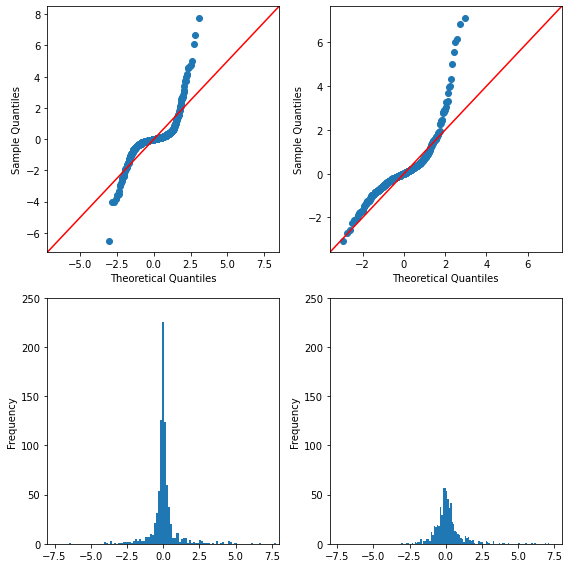

In [105]:
fr_target = full_train.loc[full_train.COUNTRY==0,"TARGET"]
de_target = full_train.loc[full_train.COUNTRY==1,"TARGET"]
# fr_target = df_same_day.loc[df_same_day.COUNTRY==0,"TARGET"]
# de_target = df_single_day["TARGET"]

print(ks_2samp(fr_target, de_target))
print('fr and de are statistically significant that they are two different distributions')

fig, axs = plt.subplots(2,2,figsize=(8,8))
sm.qqplot(fr_target, line='45', ax=axs[0][0])
sm.qqplot(de_target, line='45', ax=axs[0][1])

fr_target.plot.hist(bins=100, ax=axs[1][0])
axs[1][0].set_xlim(-8, 8)
axs[1][0].set_ylim(0, 250)
de_target.plot.hist(bins=100, ax=axs[1][1])
axs[1][1].set_xlim(-8, 8)
axs[1][1].set_ylim(0, 250)

plt.tight_layout()
plt.show()


In [48]:
drop_X_dict = {
    'fr': drop_cols_fr + ["TARGET", "DAY_ID", "RANK", "COUNTRY"],
    'de': drop_cols_de + ["TARGET", "DAY_ID", "RANK", "COUNTRY"],
    'both': drop_cols_both + ["TARGET", "DAY_ID", "RANK"]
}
ds = RegionalDatasets(fe1_train, dfr=df_single_day, exclude_X_cols_by_region=drop_X_dict, y_col='RANK', valid_ratio=0.2, holdout_ratio=0.2)
# ds = RegionalDatasets(fe1_train, exclude_X_cols_by_region=drop_X_dict, y_col='TARGET')
ds_X_y_dict = ds.to_dict()

In [19]:
drop_X_dict_test = {
    'fr': drop_cols_fr+['DAY_ID', 'COUNTRY'],
    'de': drop_cols_de+['DAY_ID', 'COUNTRY'],
    'both': drop_cols_both+['DAY_ID'],
}

ds_test = RegionalDatasets(X_test, exclude_X_cols_by_region=drop_X_dict_test)
ds_test_X_y_dict = ds_test.to_dict()

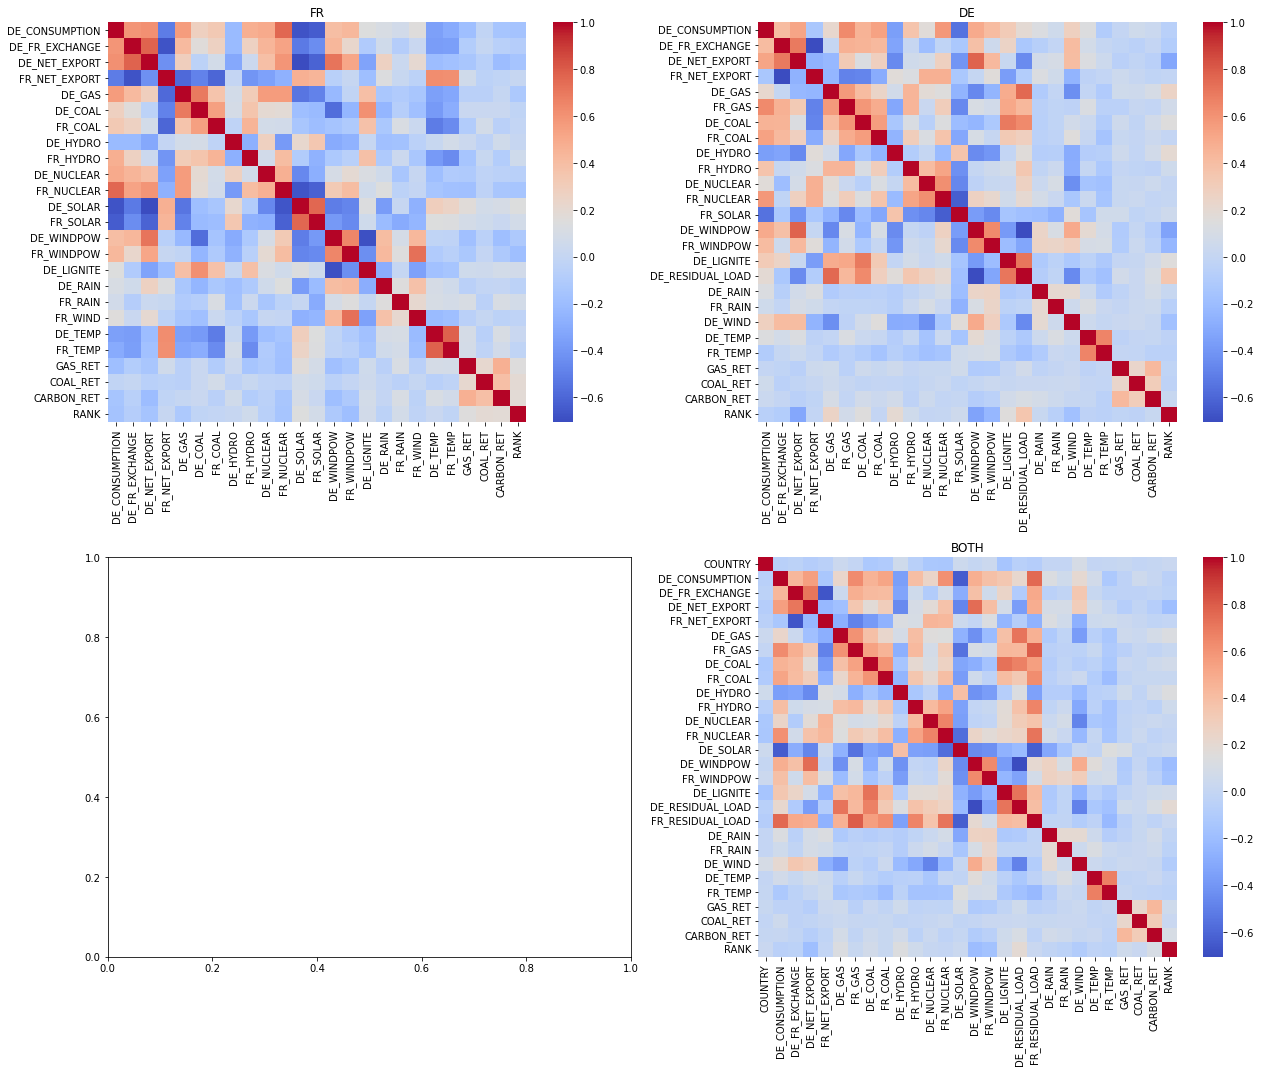

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(18,15))
# tmp = ds.dataset_fr.X_train.join(ds.dataset_fr.y_train).join(ds.dataset_fr.dtrain.TARGET)
tmp = ds.dataset_fr.dfull.drop(drop_cols_fr+["TARGET", 'DAY_ID', 'COUNTRY'], axis=1)
ax = sns.heatmap(tmp.corr(method="pearson"), cmap='coolwarm', ax=axs[0][0])
axs[0][0].set_title("FR")

tmp = ds.dataset_de.dfull.drop(drop_cols_de+["TARGET", 'DAY_ID', 'COUNTRY'], axis=1)
ax = sns.heatmap(tmp.corr(method="pearson"), cmap='coolwarm', ax=axs[0][1])
axs[0][1].set_title("DE")

tmp = ds.dataset_full.dfull.drop(drop_cols_both+["TARGET", 'DAY_ID'], axis=1)
ax = sns.heatmap(tmp.corr(method="pearson"), cmap='coolwarm', ax=axs[1][1])
axs[1][1].set_title("BOTH")
fig.tight_layout()
plt.show()

# Voting Try

In [60]:
def _get_opt(model_name, opt_param_dict):
    opt_dict = {
        'lgbm': lgbm_optimizer(**opt_param_dict),
        'xgb': xgb_optimizer(**opt_param_dict),
        'rf': rf_optimizer(**opt_param_dict),
        'svr': svr_optimizer(**opt_param_dict),
        'ridge': ridge_optimizer(**opt_param_dict),
        'huber': huber_optimizer(**opt_param_dict),
        'knn': knn_optimizer(**opt_param_dict),
        'lasso': lasso_optimizer(**opt_param_dict),
        'elasticnet': elasticnet_optimizer(**opt_param_dict), 
    }
    return opt_dict[model_name]

def optimize_models(
    X_y_dict, 
    strat='voting_models', 
    models_list=['lgbm', 'xgb', 'rf', 'svr', 'ridge', 'huber', 'knn', 'lasso', 'elasticnet'], 
    regions_list=['fr', 'de', 'both'], 
    cv=0, 
    dump=True
):
    opt_param_dict = {
                'X_y_dict': X_y_dict,
                'cv': cv
            }
    for model_name in models_list:
        print(model_name)
        for region in regions_list:
            opt_param_dict['model_type'] = region
            opt = _get_opt(model_name=model_name, opt_param_dict=opt_param_dict)
            opt.run()
            if dump: opt.dump_best_model(f"{strat}/{model_name}_{region}.json")

In [61]:
# # models_list = ['elasticnet']
# regions_list = []
# optimize_models(
#     ds_X_y_dict, 
#     strat='voting_models_6_2_2_new_fr_ds', 
#     # models_list=models_list, 
#     # regions_list=regions_list,
#     cv=0,
# )

[I 2023-07-02 16:19:45,090] A new study created in memory with name: no-name-7bfd78d5-6fdb-4b0f-a63d-876f4bd2bb7b


lgbm


/Users/chantom/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Best trial among 200 trials:
  Value: 0.33478653306693157
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Best trial among 200 trials:
  Value: 0.3508833216106965
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_

/Users/chantom/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/chantom/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/chantom/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/chantom/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/chantom/opt/anaconda3/lib/python3.9/site-packages

Best trial among 200 trials:
  Value: 0.39226660332442675
Best trial among 200 trials:
  Value: 0.31647348362688543
Best trial among 200 trials:
  Value: 0.18686223301647312
svr
Best trial among 200 trials:
  Value: 0.2656997001863707
Best trial among 200 trials:
  Value: 0.23334104380995654
Best trial among 200 trials:
  Value: 0.1650072557376359
ridge
Best trial among 200 trials:
  Value: 0.3575885260513735
Best trial among 200 trials:
  Value: 0.3260681763468653
Best trial among 200 trials:
  Value: 0.18098918204898162
huber
Best trial among 200 trials:
  Value: 0.41884774329470875
Best trial among 200 trials:
  Value: 0.26253070421858493
Best trial among 200 trials:
  Value: 0.1786451242903914
knn
Best trial among 200 trials:
  Value: 0.451097966129163
Best trial among 200 trials:
  Value: 0.22709398441253043
Best trial among 200 trials:
  Value: 0.19660685049526522
lasso
Best trial among 200 trials:
  Value: 0.3115630824082327
Best trial among 200 trials:
  Value: 0.32537580704337

In [62]:
IGNORE_MODEL_LIST = []
mbox = model_box(
    'voting_models_6_2_2_new_fr_ds', 
    # ignore_models=IGNORE_MODEL_LIST,
)
model_candidates, model_scores = mbox.to_dicts()

In [77]:
X_dict = {
    'fr': fe1_train.loc[fe1_train.COUNTRY == 0].drop(drop_X_dict['fr'], axis=1),
    'de': fe1_train.loc[fe1_train.COUNTRY == 1].drop(drop_X_dict['de'], axis=1),
    'both': fe1_train.drop(drop_X_dict['both'], axis=1),
}

full_X_dict = {k: d['X'] for k, d in ds_X_y_dict['full'].items()}
test_X_dict = {k: d['X'] for k, d in ds_test_X_y_dict['full'].items()}

In [82]:
bpreds_tra, bpreds_val, bpreds_ho = [], [], []
bpreds_all = []
score_tra, score_val, score_ho = {}, {}, {}
for key in model_candidates.keys():
    rbp = RegionalBasedPredictors(key, model_candidates[key], ds_X_y_dict['train'], X_dict)
    all_pred = rbp.aggregate_predictions()
    bpreds_all.append(all_pred)

bpreds_all = pd.concat(bpreds_all, axis=1)

bpreds_tra = bpreds_all.loc[ds.dataset_full.dtrain.index]
bpreds_val = bpreds_all.loc[ds.dataset_full.dvalid.index]
bpreds_ho = bpreds_all.loc[ds.dataset_full.dholdout.index]

In [96]:
for col in bpreds_tra.columns:
    # print("train", col, metric_train(bpreds_tra.loc[:, col], ds.dataset_full.y_train))
    # print("valid", col, metric_train(bpreds_val.loc[:, col], ds.dataset_full.y_valid))
    print("holdout", col, metric_train(bpreds_ho.loc[:, col], ds.dataset_full.y_holdout))

holdout ridge_both_pred 0.227540571479877
holdout ridge_regional_pred 0.11330834324706517
holdout lasso_both_pred 0.23203654238962088
holdout lasso_regional_pred 0.12925860250050505
holdout huber_both_pred 0.23585418958048082
holdout huber_regional_pred 0.1270296963031133
holdout rf_both_pred 0.2831873583084555
holdout rf_regional_pred 0.24352466321621613
holdout lgbm_both_pred 0.21832057641803773
holdout lgbm_regional_pred 0.2253250688727766
holdout svr_both_pred 0.2745159480146349
holdout svr_regional_pred 0.32621310408296106
holdout elasticnet_both_pred 0.2323570739152881
holdout elasticnet_regional_pred 0.11332630019528182
holdout knn_both_pred 0.2627262661172732
holdout knn_regional_pred 0.2700077226126579
holdout xgb_both_pred 0.2564739575401194
holdout xgb_regional_pred 0.2495473399190762


In [98]:
n_models = len(model_candidates)
weights = np.ones(n_models*2)
# weights = 1 / np.array(score_tra)
# weights = np.array(list(score_val.values()))

train_pred = bpreds_tra.apply(lambda x: x @ weights / np.sum(weights), axis=1)
print(metric_train(train_pred, ds_X_y_dict['train']['both']['y']))

val_pred = bpreds_val.apply(lambda x: x @ weights / np.sum(weights), axis=1)
print(metric_train(val_pred, ds_X_y_dict['valid']['both']['y']))

ho_pred = bpreds_ho.apply(lambda x: x @ weights / np.sum(weights), axis=1)
print(metric_train(ho_pred, ds_X_y_dict['holdout']['both']['y']))

0.46225597547958436
0.233989398654946
0.2821135328050998


In [99]:
bpreds_full, bpreds_test = [], []
for key in model_candidates.keys():
    rbp = RegionalBasedPredictors(key, model_candidates[key], ds_X_y_dict['full'], test_X_dict)
    bpreds_test.append(rbp.aggregate_predictions())

    # rbp.prediction_X = full_X_dict
    # bpreds_full.append(rbp.aggregate_predictions(dist_params=dist_params))

bpreds_test = pd.concat(bpreds_test, axis=1)

In [102]:
# Best # sub14
submission = bpreds_test.apply(lambda x: x @ weights / np.sum(weights), axis=1).rename('TARGET')
submission.to_csv('sub18_single_fr.csv')
submission

ID
1115    0.056030
1202    0.993137
1194   -1.183855
1084    1.033027
1135   -0.294151
          ...   
879    -1.986660
673    -0.388341
1641    1.093357
712     1.737457
1060    0.750241
Name: TARGET, Length: 654, dtype: float64

In [103]:
print(1 - metric_train(pd.read_csv('sub14.csv')['TARGET'], submission))
print(1 - pearsonr(pd.read_csv('sub14.csv')['TARGET'], submission)[0])

0.06794591313966558
0.05501168149199942


# Stacking Try

In [134]:
ds_meta = RegionalDatasets(fe1_train, 0.4, 0.2, drop_X_dict, 'RANK')
ds_meta_X_y_dict = ds_meta.to_dict()

In [135]:
# models_list=['lgbm', 'xgb', 'rf', 'svr', 'ridge', 'huber']
# regions_list=['fr', 'de', 'both']
# optimize_models(
#     ds_meta_X_y_dict, 
#     strat='base_models_4_4_2_cv_5', 
#     models_list=models_list, 
#     regions_list=regions_list,
#     cv=5,
# )

In [136]:
IGNORE_MODEL_LIST = ['lgbm', 'xgb', 'rf']
mbox_base = model_box(
    'base_models_4_4_2_cv_5', 
    # ignore_models=IGNORE_MODEL_LIST
)
model_candidates, model_scores = mbox_base.to_dicts()

In [137]:
train_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['train'].items()}
val_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['valid'].items()}
ho_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['holdout'].items()}
full_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['full'].items()}
test_X_dict = {k: d['X'] for k, d in ds_test_X_y_dict['full'].items()}

In [138]:
bpreds_tra, bpreds_val, bpreds_ho = [], [], []
for key in model_candidates.keys():
    rbp = StackingPredictor(key, model_candidates[key], ds_meta_X_y_dict['train'], val_X_dict)
    train_preds, val_preds = rbp.aggregate_predictions()
    bpreds_tra.append(train_preds)
    bpreds_val.append(val_preds)

    rbp.prediction_X = ho_X_dict
    _, ho_preds = rbp.aggregate_predictions()
    bpreds_ho.append(ho_preds)

bpreds_tra = pd.concat(bpreds_tra, axis=1)
bpreds_val = pd.concat(bpreds_val, axis=1)
bpreds_ho = pd.concat(bpreds_ho, axis=1)

In [139]:
print(metric_train(bpreds_tra.mean(axis=1), ds_meta_X_y_dict['train']['both']['y']))
print(metric_train(bpreds_val.mean(axis=1), ds_meta_X_y_dict['valid']['both']['y']))
print(metric_train(bpreds_ho.mean(axis=1), ds_meta_X_y_dict['holdout']['both']['y']))

0.31118642928376916
0.20574125956309386
0.3113425063410473


In [140]:
meta_X_tra = ds_meta_X_y_dict['train']['both']['X'].join(bpreds_tra)
meta_X_val = ds_meta_X_y_dict['valid']['both']['X'].join(bpreds_val)
meta_X_ho = ds_meta_X_y_dict['holdout']['both']['X'].join(bpreds_ho)

In [141]:
lv2_X_y_dict = {
    'train': {
        'both': {
            'X': meta_X_tra,
            'y': ds_meta_X_y_dict['train']['both']['y'],
        },
    },
    'valid': {
        'both': {
            'X': meta_X_val,
            'y': ds_meta_X_y_dict['valid']['both']['y'],
        },
    },
}

In [142]:
lv2 = xgb_optimizer(lv2_X_y_dict)
lv2.run()

Best trial among 200 trials:
  Value: 0.22859647351737497


In [143]:
lv2.model.fit(meta_X_tra, ds_meta_X_y_dict['train']['both']['y'])

XGBRegressor(alpha=0.014657245282989503, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5019323442722154, early_stopping_rounds=None,
             enable_categorical=False, eta=3.823673738541643e-06,
             eval_metric=None, feature_types=None, gamma=3.933349103551623e-06,
             gpu_id=None, grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, lambda=0.07737022194752848,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=16, min_child_weight=62, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

In [145]:
print(metric_train(lv2.model.predict(meta_X_tra), ds_meta_X_y_dict['train']['both']['y']))
print(metric_train(lv2.model.predict(meta_X_val), ds_meta_X_y_dict['valid']['both']['y']))
print(metric_train(lv2.model.predict(meta_X_ho), ds_meta_X_y_dict['holdout']['both']['y']))

0.41016583878451474
0.22859647351737497
0.30028385458639406


In [146]:
bpreds_full, bpreds_test = [], []
for key in model_candidates.keys():
    rbp = StackingPredictor(key, model_candidates[key], ds_meta_X_y_dict['full'], test_X_dict)
    full_preds, test_preds = rbp.aggregate_predictions()
    bpreds_full.append(full_preds)
    bpreds_test.append(test_preds)

bpreds_test = pd.concat(bpreds_test, axis=1)
bpreds_full = pd.concat(bpreds_full, axis=1)
meta_X_test = test_X_dict['both'].join(bpreds_test)
meta_X_full = ds_meta_X_y_dict['full']['both']['X'].join(bpreds_full)

lv2.model.fit(meta_X_full, ds_meta_X_y_dict['full']['both']['y'])

XGBRegressor(alpha=0.014657245282989503, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5019323442722154, early_stopping_rounds=None,
             enable_categorical=False, eta=3.823673738541643e-06,
             eval_metric=None, feature_types=None, gamma=3.933349103551623e-06,
             gpu_id=None, grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, lambda=0.07737022194752848,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=16, min_child_weight=62, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

In [147]:
submission2 = pd.Series(lv2.model.predict(meta_X_test), index=test_X_dict['both'].index)
submission2.name = 'TARGET'
# submission2.to_csv('sub17_meta.csv')

In [148]:
print(1 - metric_train(pd.read_csv('sub11.csv')['TARGET'], submission2))
print(1 - pearsonr(pd.read_csv('sub11.csv')['TARGET'], submission2)[0])

0.1259506271163372
0.10194419068170502


In [149]:
print(1 - metric_train(submission2, submission))
print(1 - pearsonr(submission2, submission)[0])

0.05233695977997865
0.05393760424485117
